# Import library

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
# from factor_analyzer import FactorAnalyzer

# Prepare data

In [60]:
data = pd.read_csv("DATA/infant_mortality_data_1999_2022_cleaned.csv")

In [43]:
data.head()

,Cause of death,Age of mother,Mother's education,Birth weight,Age of infant at death,Deaths,Births,Death rate per 1000,Year
0,Certain infectious and parasitic diseases,15-19,High School Incomplete,500 - 999,672 - 8736,14,1927,7.265179,1999
1,Certain infectious and parasitic diseases,15-19,High School Incomplete,2500 - 2999,672 - 8736,11,31891,0.344925,1999
2,Certain infectious and parasitic diseases,15-19,High School Incomplete,3000 - 3499,672 - 8736,10,31891,0.313568,1999
3,Certain infectious and parasitic diseases,20-24,High School Incomplete,500 - 999,672 - 8736,15,1179,12.722646,1999
4,Certain infectious and parasitic diseases,20-24,High School Graduate,500 - 999,672 - 8736,17,2490,6.827309,1999


In [44]:
data.dtypes

Cause of death             object
Age of mother              object
Mother's education         object
Birth weight               object
Age of infant at death     object
Deaths                      int64
Births                      int64
Death rate per 1000       float64
Year                        int64
dtype: object

# Kmeans

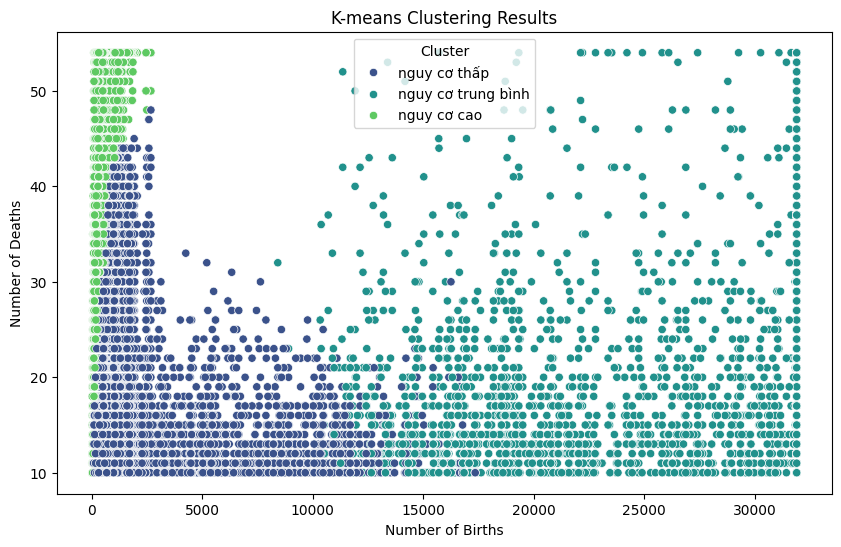

In [45]:
features = data[['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death', 'Deaths', 'Births', 'Death rate per 1000']]

# Chuyển đổi các cột phân loại thành các biến giả (one-hot encoding)
categorical_features = ['Cause of death', 'Age of mother', "Mother's education", 'Birth weight', 'Age of infant at death']
numeric_features = ['Deaths', 'Births', 'Death rate per 1000']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Áp dụng tiền xử lý dữ liệu
scaled_features = preprocessor.fit_transform(features)

# Phân tích phân cụm
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

cluster_labels = {0: "nguy cơ thấp", 1: "nguy cơ cao", 2: "nguy cơ trung bình"}
data['cluster_label'] = data['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Births', y='Deaths', hue='cluster_label', data=data, palette='viridis')
plt.title('K-means Clustering Results')
plt.xlabel('Number of Births')
plt.ylabel('Number of Deaths')
plt.legend(title='Cluster')
plt.show()

# Model

## Random Forest

In [46]:
df = data.copy()

In [47]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [48]:
X = df.drop('Deaths', axis=1)
y = df['Deaths']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.53
